RBA theta

what we have
- all turbine data.py 
- RBAtheta concept plot
- spatial markov plots(we need pdf version)

what we need still
- RBAtheta event plot, all parameters in one plot of a part of the real data(we already have it for up and down ramps)
  deltaw,f(deltaw),deltat,f(deltat), theta, f(theta), mean,f(mean), persistence from persistent events, rainflow cycles
  we can add these as TABLES(NUMBERS NEED UPDATE)
- seperate event plot for persistence
- periodogram and filtered plot from ninja dataset 2x2
- the structure of the nn
- forecast plot (the input and the forecast)
- scenarios 3(+1 forecast)x4 features
- flowchart of the whole thing

- the algorithm for persistence, update for RBAtheta, markov-scenario, frequency


In [1]:
def normalize(wind_data,nominal):
    import numpy as np
    
    norm=wind_data/nominal
    #writer = pd.ExcelWriter('C:\\Users\\\esino\\Dropbox\\Master Thesis Work - Esin Ören\\Data\\normalized.xlsx')
    #norm.to_excel(writer,sheet_name='Sheet1',columns=col)
    #writer.save()
    return norm

In [2]:
def bspline(wind_cf, s,k): 
    
    import numpy as np
    import scipy.interpolate as interpolate
    x= np.arange(len(wind_cf))
    t, c, k = interpolate.splrep(x, wind_cf, s=s, k=k) 
    #t=vector of knots, c=bspline coeff, k=degree of spline

    N=10*len(x)  #makes the data /minute
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    bsplined=interpolate.splev(xx,[t,c,k],der=0)
    return bsplined

In [3]:
def filterb(splined,fc):

    from scipy import signal
    import numpy as np
    
    b = 0.08
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)
 
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    filtered = np.convolve(splined, sinc_func)
    filtered=filtered[25:-25]
    
   
    return filtered

In [ ]:
 '''
    #for the plot of original and the filtered data (Figure 3.b)
    import scipy.interpolate as interpolate
    import matplotlib.pyplot as plt

    x = np.arange(len(splined))
    y = splined
    N = len(filtered)
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)

    from pylab import figure, scatter, show
    fig=figure(figsize=(9,6))
    plt.plot(x, y, 'k', label='Original points')
    plt.plot(xx, filtered,'r', label='fc=0.3 Hz')

    plt.xlabel('Time [/min]')
    plt.ylabel('Power [W/W]')
    plt.plot()
    plt.grid()
    plt.legend(loc='best')
    fig.savefig(b"C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\pictures_inpdf\filtered.pdf", bbox_inches='tight')
    plt.show()
    
   
    #for the periodogram plot (Figure 3a)
    
    from pylab import plot, figure, scatter, show

    fig=figure(figsize=(9,6))
    f,Pxx_den = signal.periodogram(filtered, fs=1/60)
    f,Pxx_den = signal.welch(filtered, fs=1/60,window='blackman',nperseg=len(filtered))
    plt.semilogy(f, Pxx_den)
    #plt.ylim([1e-7, 1e7])
    plt.xlabel('Frequency [Hz]')
    plt.grid()
    plt.ylabel('PSD [V^2/Hz]')
    fig.savefig(b"C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\pictures_inpdf\periodogram.pdf", bbox_inches='tight')
    plt.show()'''
    

In [4]:
def unique_rows(A, return_index=False, return_inverse=False):
    """
    Similar to MATLAB's unique(A, 'rows'), this returns B, I, J
    where B is the unique rows of A and I and J satisfy
    A = B[J,:] and B = A[I,:]

    Returns I if return_index is True
    Returns J if return_inverse is True
    """
    A = np.require(A, requirements='C')
    assert A.ndim == 2, "array must be 2-dim'l"

    B = np.unique(A.view([('', A.dtype)]*A.shape[1]),
            return_index=return_index,
            return_inverse=return_inverse)

    if return_index or return_inverse:
        return (B[0].view(A.dtype).reshape((-1, A.shape[1]), order='C'),) \
                + B[1:]
    else:
        return B.view(A.dtype).reshape((-1, A.shape[1]), order='C')

In [5]:
def freq(binn,array):
    
    import numpy as np
    
    freq=np.zeros((len(binn),1))
    persi=np.zeros((len(array),1))
    for k in range(len(binn)-1): 
        for i in range(len(array)):
            if array[i]==binn[k]or binn[k] < array[i]< binn[k+1]:
                freq[k]+=1 #how many times this(between the range of particular bin) occured
    
    for k in range(len(binn)-1): 
        for i in range(len(array)):
            if array[i]==binn[k]or binn[k] < array[i]< binn[k+1]:
                persi[i]=freq[k]
    return persi

In [6]:
def signif_events(filtered,threshold,bins):
    #threshold*= if the change in amplitude is bigger than or equal to the threshold, there is a significant event
    #bins*= number of bins that the range of parameters (∆a(-1,1), ∆t(1,max(∆t)), α(-90,90), mean(min(mean),max(mean))) will be divided into, to count the frequency of the events that fall into those bins
    
    import numpy as np
    from numpy import sign
    from pandas import Series,DataFrame
    
    delta=np.diff(filtered)  #the change between consequential points 
    
    #consequential events
    events=np.empty([1,4])
    lengths=np.empty([1,2])
    start=0
    for i in range(len(delta)-1):
        
        if sign(delta[i])== sign(delta[i+1]):
            continue
        else:
            new_event=np.array([filtered[start],filtered[i+1],start,i+1])
            events=np.row_stack((events,new_event)) #new row
            start=i+1
    events=events[1:]
    
    #amplitude and length(time) of those events
    for i in range(len(events)):
        lengths=np.row_stack((lengths,[events[i,1]-events[i,0],events[i,3]-events[i,2]]))
    lengths=lengths[1:]
            
    #sifted events with a threshold
    neglect = np.ones(len(lengths), dtype=bool)
    
    for i in range(len(lengths)):
        if abs(lengths[i,0])< threshold:
            neglect[i]=False
    
    
    masked=events[neglect]
    masked_lg=np.empty([1,2])
    for i in range(len(masked)):
        masked_lg=np.row_stack((masked_lg,[masked[i,1]-masked[i,0],masked[i,3]-masked[i,2]]))
    masked_lg=masked_lg[1:]
    new_masked=masked
    for i in range(len(masked)-1):
        if sign(masked_lg[i,0])==sign(masked_lg[i+1,0]):
            new_masked[i,1]=masked[i+1,1]
            new_masked[i,3]=masked[i+1,3]
            new_masked=np.delete(masked,(i+1),axis=0)
                       
    
    
    lg=np.empty([1,2])
    for i in range(len(new_masked)):
        lg=np.row_stack((lg,[new_masked[i,1]-new_masked[i,0],new_masked[i,3]-new_masked[i,2]]))
    lg=lg[1:]

    
    angles=[]
    for i in range(len(lg)):

        new=lg[i,0]*10/lg[i,1]
        angles.append(new)

    angles=np.arctan(angles)
    angles=np.degrees(angles)
    
    events=np.append(new_masked,lg,axis=1)
    events=np.c_[events,angles]

    
    mean=[]
    for i in range(len(events)):
        mean.append((events[i,0]+events[i,1])/2)
    events=np.c_[events,mean]
   
    #frequency
    amp_bins=np.linspace(-1,1,bins)
    a=events[:,4]
    amp_fre=freq(amp_bins,a)
    
    max_time=max(events[:,5])
    time_bins=np.linspace(min(events[:,5]),max(events[:,5]),bins)
    b=events[:,5]
    time_fre=freq(time_bins,b)
    
    angle_bins=np.linspace(-90,90,bins)
    c=events[:,6]
    angle_fre=freq(angle_bins,c)
    
    mean_bins=np.linspace(min(mean),max(mean),bins)
    d=events[:,7]
    mean_fre=freq(mean_bins,d)

    events=np.append(events,amp_fre,axis=1) 
    events=np.append(events,time_fre,axis=1) 
    events=np.append(events,angle_fre,axis=1) 
    events=np.append(events,mean_fre,axis=1) 
    Events=DataFrame(events,columns=['w_s(t)','w_s(t+∆t)','t','t+∆t','∆w_s','∆t','θ(∆w_s)','mean(∆w_s)','f(∆w_s)','f(∆t)','f(θ(∆w_s))','f(mean(∆w_s))'])

    
    return Events

In [7]:
def pers_events(filtered,threshold):
    #threshold*= if the change in amplitude is smaller the threshold, there might be a significant event
    
    import numpy as np
    from numpy import sign
    import pandas as pd
    
    col=['w_s(t)','w_s(t+∆t)','t','t+∆t','mean','∆t']
    events=pd.DataFrame(columns=col)  
    
    t=len(filtered) 
    i=0
    while i<t: #loop over the timeline
        k=t-i
        pers=1
        for j in range(1,k):   #loop to compare
            if (abs(filtered[i+j]-filtered[i]) < threshold)and ((filtered[i+j]-filtered[i+j-1])<threshold) : 
                pers+=1
            else:
                new=pd.DataFrame([[filtered[i],filtered[i+pers],i,i+pers,(filtered[i+pers]+filtered[i])/2,pers]],columns=col)
                events=events.append(new)
                i=i+1
                break
        i+=1 
          
    persistent_events=pd.DataFrame(columns=col)
    periods=int(t/480)+1
    p_bins=np.linspace(0,t,periods)   #183 periods
    
    for i in range(len(p_bins)-1):
        new=pd.DataFrame(columns=col)
        
        for k in range(len(events)):
            if p_bins[i]<events.iloc[k,3]<p_bins[i+1]:
                new=new.append(events.iloc[k,:])
            #print(new)
        new=new.sort_values(by=['∆t','mean'],ascending=False)
        #print(new)
        persistent_events= persistent_events.append(new.iloc[0])  

    return persistent_events    
    '''
#compare adjacent and take the longer one
            
   
    max_time=max(events.iloc[:,5])
    time_bins=np.linspace(min(events.iloc[:,5]),max(events.iloc[:,5]),bins)
    events['f(∆t)']=freq(time_bins,events.iloc[:,5])
    
    
 
    masked=events[neglect]
    masked_lg=np.empty([1,2])
    for i in range(len(masked)):
        masked_lg=np.row_stack((masked_lg,[masked[i,1]-masked[i,0],masked[i,3]-masked[i,2]]))
    masked_lg=masked_lg[1:]
    new_masked=masked
    
    for i in range(len(masked)-1):
        if new_masked[i,2])==new_masked[i+1,3]:
            new_masked[i,1]=masked[i+1,1]
            new_masked[i,3]=masked[i+1,3]
            new_masked=np.delete(masked,(i+1),axis=0)
                       
    
    
    lg=np.empty([1,2])
    for i in range(len(new_masked)):
        lg=np.row_stack((lg,[new_masked[i,1]-new_masked[i,0],new_masked[i,3]-new_masked[i,2]]))
    lg=lg[1:]
   
    angles=[]
    for i in range(len(lg)):

        new=lg[i,0]*10/lg[i,1]
        angles.append(new)

    angles=np.arctan(angles)
    angles=np.degrees(angles)
    
    events=np.append(new_masked,lg,axis=1)
    events=np.c_[events,angles]

    
    mean=[]
    for i in range(len(events)):
        mean.append((events[i,0]+events[i,1])/2)
    events=np.c_[events,mean]
   
    def pers(binn,array):
        freq=np.zeros((len(binn),1))
        persi=np.zeros((len(array),1))
        for k in range(len(binn)-1): 
            for i in range(len(array)):
                if array[i]==binn[k]or binn[k] < array[i]< binn[k+1]:
                    freq[k]+=1 #how many times this(between the range of particular bin) occured
    
        for k in range(len(binn)-1): 
            for i in range(len(array)):
                if array[i]==binn[k]or binn[k] < array[i]< binn[k+1]:
                    persi[i]=freq[k]
        return persi
    
    
    
    amp_bins=np.linspace(-1,1,bins)
    a=events[:,4]
    amp_pers=pers(amp_bins,a)
    
    max_time=max(events[:,5])
    time_bins=np.linspace(min(events[:,5]),max(events[:,5]),bins)
    b=events[:,5]
    time_pers=pers(time_bins,b)
    
    angle_bins=np.linspace(-90,90,bins)
    c=events[:,6]
    angle_pers=pers(angle_bins,c)
    
    mean_bins=np.linspace(min(mean),max(mean),bins)
    d=events[:,7]
    mean_pers=pers(mean_bins,d)

    events=np.append(events,amp_pers,axis=1) 
    events=np.append(events,time_pers,axis=1) 
    events=np.append(events,angle_pers,axis=1) 
    events=np.append(events,mean_pers,axis=1) 
    Events=DataFrame(events,columns=['w_s(t)','w_s(t+∆t)','t','t+∆t','∆w_s','∆t','θ(∆w_s)','mean(∆w_s)','f(∆w_s)','f(∆t)','f(θ(∆w_s))','f(mean(∆w_s))'])

    
    return Events'''


In [8]:
def RBA_theta(wind_data_path, nominal, s=0.01,k=3, fc=0.3, threshold=0.15, bins=100):
    #nominal= nominal value in Watts
    #s=smoothness factor of Bspline
    #k=degree of Bspline
    #fc=cutoff frequency for Blackman filter
    # add into the function later shapefile
    

    from pandas import Series,DataFrame
    import pandas as pd
    import matplotlib.pyplot as plt
    
    import scipy
    import math
    
    #wind_data=[amplitude through time(/10minutes), # of turbines] in Watts
    wind_data = pd.read_excel(wind_data_path, sheetname=0)
    #wind_data=wind_data.iloc[:200,:]
    n=len(wind_data.columns) #n=number of turbines
    t=len(wind_data)
    
    col=[]
    for i in range(1,n+1):
        col.append('WT'+'%s' %str(i)) #column names as WT1,WT2,WT3,...
    
    #predefining 
    wind_cf=pd.DataFrame(columns=col) 
    splined=pd.DataFrame(columns=col)
    filtered=pd.DataFrame(columns=col)
    significant_events=pd.Panel() 
    persistent_events=pd.Panel()

    for i in range(n):
        
        wind_cf.iloc[:,i]=normalize(wind_data.iloc[:,i].values,nominal)  #wind_cf=capacity factors in W/W
        splined.iloc[:,i]=bspline(wind_cf.iloc[:,i],s,k)    #splined=smoothed data with bspline in 
        filtered.iloc[:,i]=filterb(splined.iloc[:,i],fc)    #filtered=blackman filtered data with fc
    tao=len(filtered)    
    #initializing the panels
    significant_events={'WT1': signif_events(filtered.iloc[:,0],threshold,bins)}
    persistent_events={'WT1': pers_events(filtered.iloc[:,0],threshold)}
    
    # the event information for every turbine is in the panel as a dataframe named 'WT1,WT2,..'
    for i in range(n):
        
        significant_events[col[i]]= signif_events(filtered.iloc[:,i],threshold,bins)
        persistent_events[col[i]]= pers_events(filtered.iloc[:,i],threshold) 
    #delta_w=significant_events.minor_xs(4)#'∆w_s'
    #delta_t=significant_events.minor_xs(5)#'∆t'
    #theta=significant_events.minor_xs(6)#'θ(∆w_s)'
    #mean=significant_events.minor_xs(7)#'mean(∆w_s)'
    
    return  [persistent_events,significant_events, tao]#significant_events['WT1'],filtered.iloc[:,0]] delta_w,delta_t,theta,mean

In [ ]:
def pre_markov(s_events,p_events,tao): 
    '''#takes in the output of RBA_theta
    #gives out the matrices that will go into markov()
    #to coincide the events timewise for the turbines, 
    it repeats the value of the parameter over the period of time
    that particular event occurs
    e.g say for the parameter '∆w_s', there are events between t=2 
    and t=5 with ∆w_s=0.3 and between t=7 and t=8 with ∆w_s=0.15, 
    the series of data for ∆w_s goes:
    0,0,0.3,0.3,0.3,0.3,0,0.15,0.15,...
    This way all series of parameters for turbines coincide.
    '''
    import numpy as np
    import pandas as pd
    import math
    
    significant_events=pd.Panel(s_events)
    start=significant_events.minor_xs('t')
    end=significant_events.minor_xs('t+∆t')
    col=start.columns.values.tolist()
    
    #initializing the parameter matrices with 0 when there is no event

    n=start.shape[1]
    k=start.shape[0]
    t=tao
    delta_w=pd.DataFrame(np.zeros((t,n)),columns=col)
    delta_t=pd.DataFrame(np.zeros((t,n)),columns=col)
    theta=pd.DataFrame(np.zeros((t,n)),columns=col)
    mean=pd.DataFrame(np.zeros((t,n)),columns=col)
    
    
    for i in range(n):
        for m in range(k):
            if math.isnan(start.iloc[m,i]):
                break
            else:
                a=int(start.iloc[m,i])
                b=int(end.iloc[m,i])
                delta_w.iloc[a:b,int(i)]=significant_events.loc[col[i],m,'∆w_s']
                delta_t.iloc[a:b,int(i)]=significant_events.loc[col[i],m,'∆t']
                theta.iloc[a:b,int(i)]=significant_events.loc[col[i],m,'θ(∆w_s)']
                mean.iloc[a:b,int(i)]=significant_events.loc[col[i],m,'mean(∆w_s)']
            
    delta_w=pd.DataFrame(delta_w,columns=col)
    delta_t=pd.DataFrame(delta_t,columns=col)
    theta=pd.DataFrame(theta,columns=col)
    mean=pd.DataFrame(mean,columns=col)
            
    return [delta_w,delta_t,theta,mean]


In [ ]:
def markov(delta_w,delta_t,theta,mean,shapefile):
    import pysal as ps
    qW = pysal.weights.Queen.from_shapefile(shapefile)
    '''A commonly-used type of weights is Queen-contiguity weights, which reflects adjacency relationships as a binary 
indicator variable denoting whether or not a polygon shares an edge or a vertex with another polygon. These weights 
are symmetric.'''
    
    amp_lm = pysal.LISA_Markov(delta_w, qW)
    t_lm = pysal.LISA_Markov(delta_t, qW)
    theta_lm = pysal.LISA_Markov(theta, qW)
    mean_lm = pysal.LISA_Markov(mean, qW)
    
    return [amp_lm,t_lm,theta_lm,mean_lm]
    

In [9]:
def pre_lstm(significant_events):
    import numpy as np
    import pandas as pd
    import math
    
    significant_events=pd.Panel(significant_events)
    significant_events=significant_events.loc['WT1']
    significant_events=significant_events.dropna()

    
    #delta_w=significant_events.minor_xs(['∆w_s','f(∆w_s)'])
    #delta_t=significant_events.minor_xs(['∆t','f(∆t)'])
    #theta=significant_events.minor_xs(['θ(∆w_s)','f(θ(∆w_s))'])
    #mean=significant_events.minor_xs(['mean(∆w_s)','f(mean(∆w_s))'])
    delta_w=significant_events[['∆w_s','f(∆w_s)']]
    delta_t=significant_events[['∆t','f(∆t)']]
    theta=significant_events[['θ(∆w_s)','f(θ(∆w_s))']]
    mean=significant_events[['mean(∆w_s)','f(mean(∆w_s))']]

    return [delta_w,delta_t,theta,mean]

In [10]:
import pandas as pd
shapefile=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\shapefile\thiesen from geoda\locations.shp'
path=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\pre_lstm.xlsx'
delta_w = pd.read_excel(path, sheetname='Sheet2')
delta_t=pd.read_excel(path, sheetname='Sheet3')
theta=pd.read_excel(path, sheetname='Sheet4')
mean=pd.read_excel(path, sheetname='Sheet5')

C:\Users\esino\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [27]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = delta_t.iloc[:,0]
# choose a number of time steps
n_steps_in, n_steps_out = 50, 20
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X, y, epochs=100, validation_split=0.33)
print(history.history['loss'])
#print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = delta_t.iloc[-50:,0]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Train on 238 samples, validate on 118 samples
Epoch 1/100
238/238 [==============================] - 3s 12ms/step - loss: 177.1058 - acc: 0.0017 - val_loss: 235.3695 - val_acc: 0.0013
Epoch 2/100
238/238 [==============================] - 1s 2ms/step - loss: 233.6319 - acc: 0.0019 - val_loss: 296.0240 - val_acc: 4.2373e-04
Epoch 3/100
238/238 [==============================] - 1s 2ms/step - loss: 196.4679 - acc: 0.0021 - val_loss: 234.4493 - val_acc: 8.4746e-04
Epoch 4/100
238/238 [==============================] - 1s 3ms/step - loss: 188.1256 - acc: 0.0017 - val_loss: 183.9171 - val_acc: 0.0025
Epoch 5/100
238/238 [==============================] - 1s 2ms/step - loss: 205.8080 - acc: 0.0023 - val_loss: 131.7586 - val_acc: 0.0021
Epoch 6/100
238/238 [==============================] - 1s 2ms/step - loss: 98.2781 - acc: 0.0015 - val_loss: 88.7096 - val_acc: 0.0013
Epoch 7/100
238/238 [==============================] - 1s 2ms/step - loss: 21.1740 - acc: 4.2017e-04 - val_loss: -88.0709 - v

238/238 [==============================] - 1s 2ms/step - loss: -369.0568 - acc: 4.2017e-04 - val_loss: -436.7662 - val_acc: 0.0000e+00
Epoch 57/100
238/238 [==============================] - 1s 2ms/step - loss: -376.6880 - acc: 0.0000e+00 - val_loss: -470.9395 - val_acc: 0.0000e+00
Epoch 58/100
238/238 [==============================] - 1s 2ms/step - loss: -396.6743 - acc: 0.0000e+00 - val_loss: -518.5635 - val_acc: 0.0000e+00
Epoch 59/100
238/238 [==============================] - 1s 2ms/step - loss: -411.4035 - acc: 0.0000e+00 - val_loss: -514.6104 - val_acc: 0.0000e+00
Epoch 60/100
238/238 [==============================] - 1s 2ms/step - loss: -396.4842 - acc: 0.0000e+00 - val_loss: -520.3695 - val_acc: 0.0000e+00
Epoch 61/100
238/238 [==============================] - 1s 2ms/step - loss: -444.1919 - acc: 0.0000e+00 - val_loss: -571.7494 - val_acc: 0.0000e+00
Epoch 62/100
238/238 [==============================] - 1s 2ms/step - loss: -404.1695 - acc: 0.0000e+00 - val_loss: -506.4863

C:\Users\esino\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


[[ -32615.844  262725.38   257731.8   -109084.73   241558.55    76412.36
   275193.9    264093.1    195492.83   -56067.844  144779.88   192192.23
    47931.97  -112811.016 -145901.34   419034.56   149724.25   291334.9
   260255.08    10665.096]]


In [20]:
print(delta_t.iloc[180:200,0])

180     61
181     79
182     52
183    100
184     92
185     36
186     90
187    132
188     48
189    268
190    193
191    105
192     92
193    120
194     68
195     56
196    104
197     41
198     43
199    127
Name: ∆t, dtype: int64


In [12]:
#This is where we saved the whole feature matrices that will be fed into lstm but for one turbine

import pandas as pd
shapefile=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\shapefile\thiesen from geoda\locations.shp'
path=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\8_wind_turbine_data.xlsx'
[p_events,significant_events,tao]=RBA_theta(path,2500)
[delta_w,delta_t,theta,mean]=pre_lstm(significant_events)

#pathh=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\pre_lstm.xlsx'
#writer = pd.ExcelWriter(pathh)
#significant_events.to_excel(writer,sheet_name='Sheet1')
#p_events.to_excel(writer,sheet_name='Sheet1')
#delta_w.to_excel(writer,sheet_name='Sheet3')
#delta_t.to_excel(writer,sheet_name='Sheet4')
#theta.to_excel(writer,sheet_name='Sheet5')
#mean.to_excel(writer,sheet_name='Sheet6')
#writer.save()


C:\Users\esino\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\Users\esino\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


IndexError: single positional indexer is out-of-bounds

In [34]:
path=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\8_wind_turbine_data.xlsx'
pers=RBA_theta(path,2500)
print(pers)

C:\Users\esino\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\Users\esino\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


[{'WT1':      w_s(t)  w_s(t+∆t)     t  t+∆t      mean   ∆t
0  0.453011   0.302288   100   477  0.377649  377
0  0.438501   0.590898   102   832  0.514699  730
0  0.264902   0.415509  1056  1389  0.340205  333
0  0.583422   0.410637  1624  1999  0.497030  375, 'WT2':      w_s(t)  w_s(t+∆t)     t  t+∆t      mean   ∆t
0  0.452068   0.301692   100   477  0.376880  377
0  0.437604   0.589696   102   831  0.513650  729
0  0.276273   0.427692  1054  1392  0.351982  338
0  0.570788   0.407954  1622  1999  0.489371  377, 'WT3':      w_s(t)  w_s(t+∆t)     t  t+∆t      mean   ∆t
0  0.481526   0.331228    94   466  0.406377  372
0  0.470820   0.621471    96   889  0.546146  793
0  0.343467   0.496763  1126  1400  0.420115  274
0  0.568648   0.389565  1616  1999  0.479107  383, 'WT4':      w_s(t)  w_s(t+∆t)     t  t+∆t      mean   ∆t
0  0.538657   0.386699     6    90  0.462678   84
0  0.415256   0.567738    82   879  0.491497  797
0  0.221153   0.374309  1034  1379  0.297731  345
0  0.540886   0.3

C:\Users\esino\Anaconda3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 2 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\esino\Anaconda3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 3, 4
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


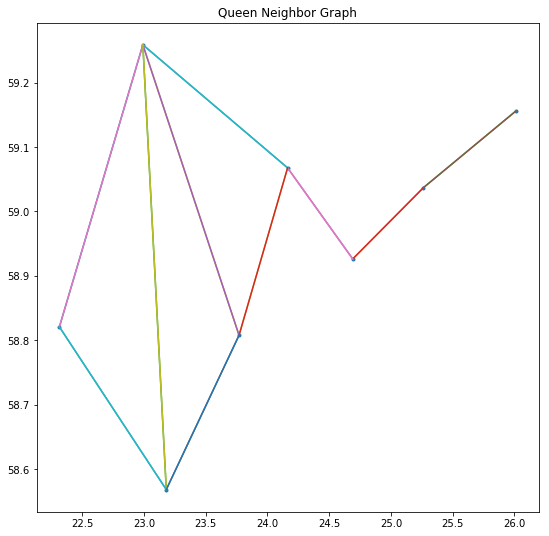

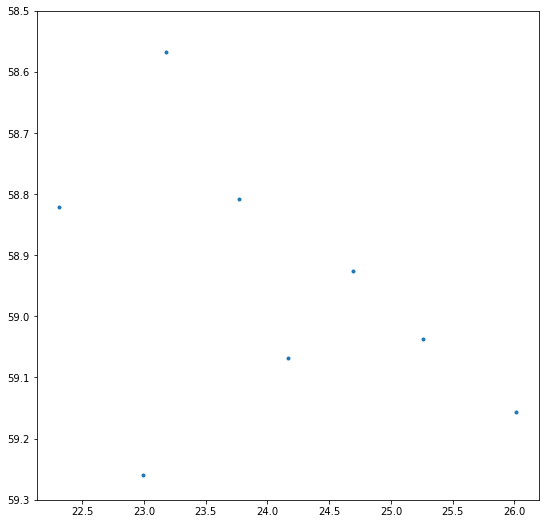

In [15]:
shapefile=r'C:\Users\esino\Dropbox\Master Thesis Work - Esin Ören\recent work\shapefile\thiesen from geoda\locations.shp'
from pylab import figure, scatter, show
import matplotlib.pyplot as plt
import pysal as ps
import numpy as np

dataframe = ps.pdio.read_files(shapefile)
radius = ps.cg.sphere.RADIUS_EARTH_KM

threshold = ps.min_threshold_dist_from_shapefile(shapefile, radius=radius) # decimal degrees
Wmind0 = ps.threshold_binaryW_from_shapefile(shapefile, radius=radius, threshold=threshold*.9)
centroids = np.array([list(poly.centroid) for poly in dataframe.geometry])

fig = figure(figsize=(9,9))

plt.plot(centroids[:,0], centroids[:,1],'.')
#plt.plot(s04[:,0], s04[:,1], '-')
#plt.ylim([59.37,59.385])
qW = ps.weights.Queen.from_shapefile(shapefile)
for k,neighs in qW.neighbors.items():
    #print(k,neighs)
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment[:,0], segment[:,1], '-')
plt.title('Queen Neighbor Graph')
fig.savefig("C:\\Users\\esino\\Desktop\\queenrelationships.pdf", bbox_inches='tight')
show()

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import figure, scatter, show

fig = figure(figsize=(9,9))
plt.plot(centroids[:,0], centroids[:,1],'.')
plt.ylim([59.3,58.5])
show()